In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np

# Step1 : Preprocessing

In [35]:
IMAGE_SIZE =256
BATCH_SIZE =32
CHANNELS =3
EPOCHS =50
NUMB_CLASSES =4

## Load Dataset from Directory

In [7]:
from google.colab import drive
import tensorflow as tf
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')

# Path to ZIP file
zip_path = "/content/drive/MyDrive/Apple Disease Dataset.zip"

# Extract ZIP
extract_path = "/content/Apple_Disease_Dataset"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

#  Detect if there is an extra folder inside
extracted_items = os.listdir(extract_path)
if len(extracted_items) == 1 and os.path.isdir(os.path.join(extract_path, extracted_items[0])):
    dataset_dir = os.path.join(extract_path, extracted_items[0])  # Go inside the main folder
else:
    dataset_dir = extract_path


# Load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 3171 files belonging to 4 classes.


In [8]:
class_names = dataset.class_names
print("Classes:", class_names)

Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy']


In [9]:
len(dataset)  #32 one batch *100 batches =3200

100

## Show 12 Images

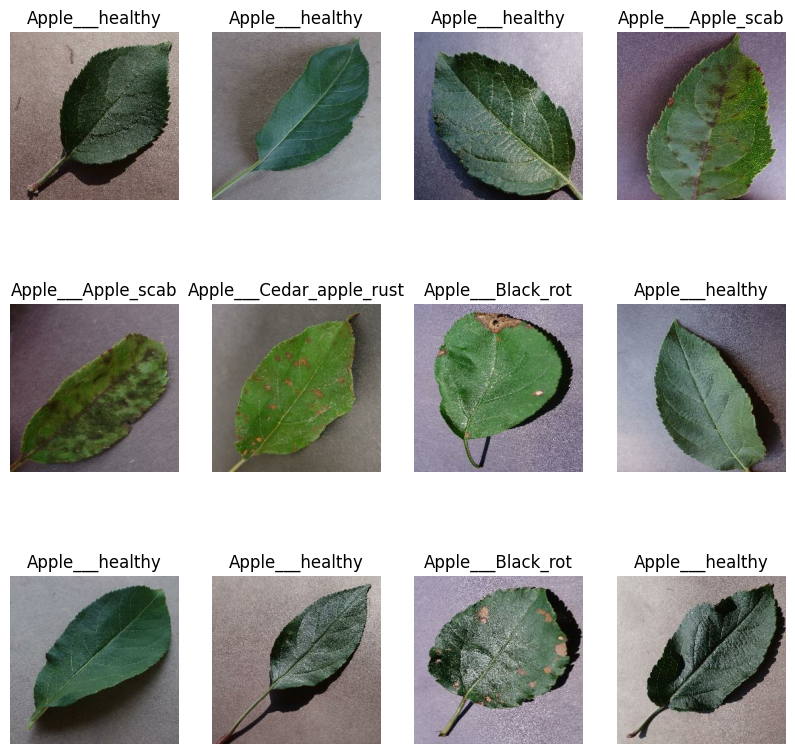

In [10]:
plt.figure(figsize = (10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax =plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
#         print(image_batch.shape)
        plt.axis('off')
#       print(label_batch.numpy())

In [11]:
# SPLIT DATA IN
# TRAIN -->80%
# VALIDATION -->10%
# TEST -->10%


In [12]:
train_size =0.8
len(dataset)*train_size #mean 80 batch for training

80.0

In [15]:
# This is our Train dataset 80% and 80 batches each batch 32
train_ds =dataset.take(80)
len(train_ds) # 80 batches

80

In [16]:
# Remaining dataset is 20%
test_ds =dataset.skip(80)
len(test_ds)

20

In [17]:
val_size =0.1
len(dataset)*val_size

10.0

In [18]:
# This is our validation dataset 10% and 10 batches each batch 32
val_ds =test_ds.take(10)
len(val_ds)

10

In [19]:
# This is our Test dataset 10% and 10 batches each batch 32
test_ds =test_ds.skip(10)
len(test_ds)

10

## Train-Test-Val Split Function

In [20]:
def get_dataset_partitaions_tf(ds,train_split =0.8 ,val_split =0.1 ,test_split =0.1,shuffle =True,shuffle_size=10000):
    ds_size =len(ds)
    if shuffle:
        ds =ds.shuffle(shuffle_size,seed=12)

        train_size =int(train_split*ds_size)
        val_size =int(val_split*ds_size)

        train_ds =ds.take(train_size)

        val_ds =ds.skip(train_size).take(val_size)
        test_ds =ds.skip(train_size).skip(val_size)

        return train_ds,val_ds,test_ds


In [21]:
train_ds, val_ds, test_ds =get_dataset_partitaions_tf(dataset)

In [22]:
len(train_ds)

80

In [23]:
len(val_ds)

10

In [24]:
len(test_ds)

10

In [25]:
# This is used for traing speed
train_ds =train_ds.cache().shuffle(1000).prefetch(buffer_size =tf.data.AUTOTUNE)
val_ds =val_ds.cache().shuffle(1000).prefetch(buffer_size =tf.data.AUTOTUNE)
test_ds =test_ds.cache().shuffle(1000).prefetch(buffer_size =tf.data.AUTOTUNE)

## Resizing and Rescaling

In [29]:
resize_and_rescale =tf.keras.Sequential([

    #Resizing images if our image is not same size 256,256 than this function convert in same size
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    # Scaling the image 0 to 1
    layers.Rescaling(1.0/255)
])

## Data Augmentation

In [30]:
data_augmentation =tf.keras.Sequential([

    # Image is flip horizontal and vertical
    layers.RandomFlip('horizontal_and_vertical'),
    # Rotate the image 20%
    layers.RandomRotation(0.2)
])

# Step2 :Build Model

In [36]:
model =models.Sequential([
    resize_and_rescale,
    data_augmentation,

    layers.Conv2D(32,(3,3),activation='relu',input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(NUMB_CLASSES,activation='softmax')

])

model.build(input_shape =(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS))

In [37]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 4)                │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,812 (718.02 KB)

 Trainable params: 183,812 (718.02 KB)

 Non-trainable params: 0 (0.00 B)

## Compile Model

In [38]:
model.compile(
    optimizer='adam',
    loss =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']

)

## Fit Model on Training and Validation data

In [40]:
hostory = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 19s 113ms/step - accuracy: 0.4999 - loss: 1.2385 - val_accuracy: 0.5533 - val_loss: 0.9287
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.6136 - loss: 0.8643 - val_accuracy: 0.7079 - val_loss: 0.6704
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.6910 - loss: 0.7226 - val_accuracy: 0.6667 - val_loss: 0.7158
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.7232 - loss: 0.6896 - val_accuracy: 0.7869 - val_loss: 0.5089
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.8318 - loss: 0.4252 - val_accuracy: 0.8625 - val_loss: 0.3163
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.8306 - loss: 0.4064 - val_accuracy: 0.8660 - val_loss: 0.3241
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.8940 - loss: 0.2889 - val_accuracy: 0.9107 - val_loss: 0.3364
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9124 - loss: 0.2168 - val_accuracy: 0.9244 -

# Check Accuarcy on Test Data

In [41]:
score = model.evaluate(test_ds)

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9827 - loss: 0.0490


## Visulization Graph

In [43]:
acc =hostory.history['accuracy']
val_acc =hostory.history['val_accuracy']

loss =hostory.history['loss']
val_loss =hostory.history['val_loss']

## Plot Accuracy and Loss Graph

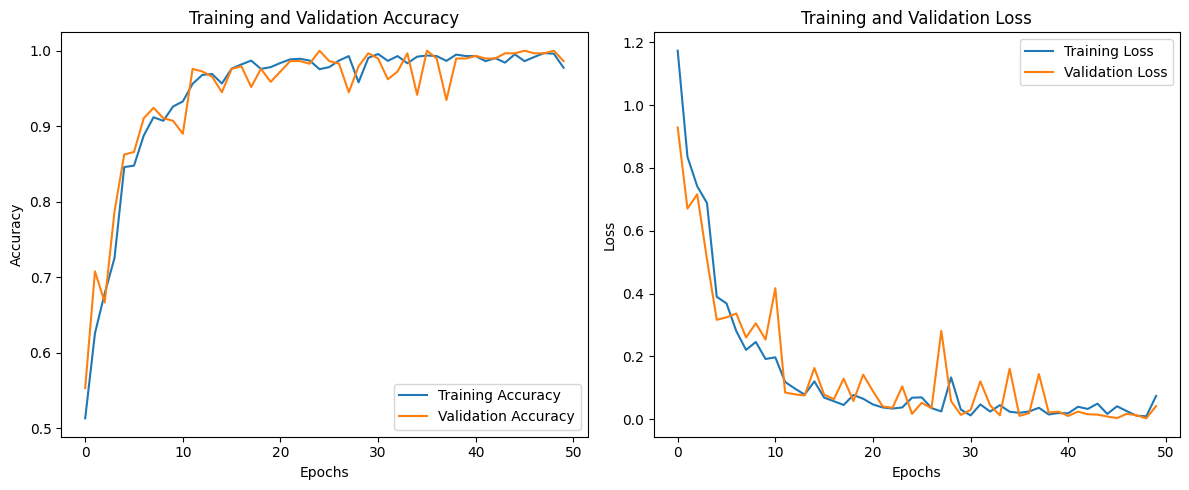

In [46]:
epochs_range = range(len(acc))

# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


## Save Model

In [54]:
# Save entire model (including optimizer, weights, and architecture)
model.save('Apple_Plant_Disease_Prediction_model.keras')  # Folder format


In [55]:
# Download to your system
from google.colab import files
files.download("Apple_Plant_Disease_Prediction_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


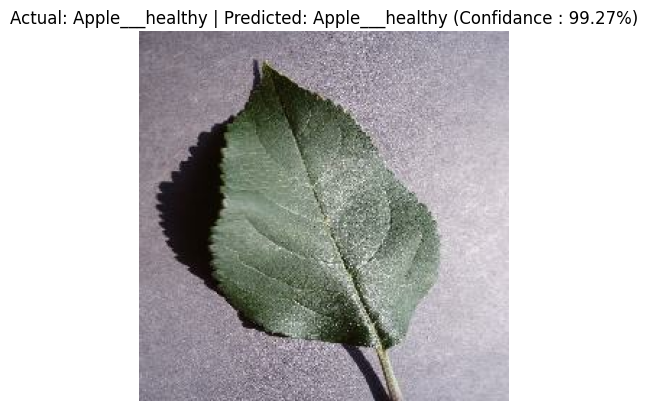

In [58]:
# Get class names from your dataset
class_names = dataset.class_names

# Take first batch from dataset
for images, labels in dataset.take(1):
    first_image = images[0].numpy()  # Convert tensor to numpy array
    first_label = labels[0].numpy()
    break

# Predict using your model
pred = model.predict(tf.expand_dims(first_image, axis=0))  # Add batch dimension

# Extract predicted class and confidence
predicted_index = np.argmax(pred)
predicted_class = class_names[predicted_index]
confidence = np.max(pred) * 100  # Convert to percentage

# Get actual label name
actual_class = class_names[first_label]

# Show the image with predicted & actual labels + confidence
plt.imshow(first_image.astype("uint8"))
plt.title(f"Actual: {actual_class} | Predicted: {predicted_class} (Confidance : {confidence:.2f}%)")
plt.axis("off")
plt.show()
